https://www.kaggle.com/competitions/airbus-ship-detection/overview

Features

1. Used DeepLabV3+ model with trained ResNet50 

https://keras.io/examples/vision/deeplabv3_plus/

Masks generated as png files


2. Class balance

Segmentation is presented as a binary classification (there is a ship or not), and we have a unbalance of classes even in one picture where there is a ship. Since class_weight cannot be used with output folds, I wrote own loss (weighted_binary_crossentropy), where weight can be set for one class.
Also I deleted pictures where there are no ships.

3. Augmentation

When augmenting, I first accidentally cut out a piece of 256 * 256. After that, I randomly flip horizontally, vertically and rotate 90 degrees (8 positions). Do the same for the mask.

I also change a little brightness, contrast, saturation, add noise.
There is no resizing, so there is no loss of information, plus it is possible to learn from pictures of any size. Also, because of the crop, a lot of pictures without ships are formed, so the original pictures without them are not needed.

4. Gradient Centralization
https://arxiv.org/abs/2004.01461

5. Checkpoin in training, threshold at predict. Predict generated by 9 parts of image

#Load data

In [ ]:
#Либо укажите путь на гугл диске(нужно подключить) или поставьте None и выберете с компьютера
path_kaggle_json = '/content/drive/MyDrive/Colab Notebooks/Kaggle/kaggle.json'
#path_kaggle_json = None 

if path_kaggle_json == None:
    from google.colab import files
    files.upload()
    path_kaggle_json = 'kaggle.json'

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp '{path_kaggle_json}' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c airbus-ship-detection
!unzip airbus-ship-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_v2/f9775b70e.jpg  
  inflating: train_v2/f977a470c.jpg  
  inflating: train_v2/f9780bfaf.jpg  
  inflating: train_v2/f9782bdfe.jpg  
  inflating: train_v2/f9785ca49.jpg  
  inflating: train_v2/f9785e462.jpg  
  inflating: train_v2/f97a719d5.jpg  
  inflating: train_v2/f97afa376.jpg  
  inflating: train_v2/f97b85e3e.jpg  
  inflating: train_v2/f97bd0b11.jpg  
  inflating: train_v2/f97bd6b80.jpg  
  inflating: train_v2/f97bfb1b2.jpg  
  inflating: train_v2/f97c8cbbe.jpg  
  inflating: train_v2/f97cdd397.jpg  
  inflating: train_v2/f97d92e1e.jpg  
  inflating: train_v2/f97da9e70.jpg  
  inflating: train_v2/f97e843d3.jpg  
  inflating: train_v2/f97e961f2.jpg  
  inflating: train_v2/f97e96c68.jpg  
  inflating: train_v2/f97f63ae1.jpg  
  inflating: train_v2/f97f80839.jpg  
  inflating: train_v2/f97f83438.jpg  
  inflating: train_v2/f97fab9ad.jpg  
  inflating: train_v2/f97fd4915.jpg  
  inflating: train_v2/f9801bc03.jpg  

#Import

In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import os, glob
import math

#Data view

In [ ]:
target_size = [256, 256] # size of image for model
shuffle_buffer = 32 
batch_size = 4 # batch size
MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/saveModels/' #dir where saving models or weights

train_dir = 'train_v2' # folder with train image
train_mask_dir = 'train_masks' # folder with masks
test_dir = 'test_v2' # folder with test image

In [ ]:
train_data = sorted(os.listdir(train_dir))

In [ ]:
submission = pd.read_csv('/content/sample_submission_v2.csv')
submission.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [ ]:
masks_df = pd.read_csv('train_ship_segmentations_v2.csv')
masks_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [ ]:
masks_df.ImageId.value_counts()

e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 192556, dtype: int64

In [ ]:
def read_mask(img_path, shape=(768, 768)):
    '''
    Create mask from lists for image
    img_path: path to image
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    image_name = os.path.basename(img_path)
    img_masks = masks_df.loc[masks_df['ImageId'] == image_name, 'EncodedPixels'].tolist()

    all_masks = np.zeros(shape)
    for mask in img_masks:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        if (pd.isna(mask) != True):
            s = mask.split()
            starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
            starts -= 1
            ends = starts + lengths
            
            for lo, hi in zip(starts, ends):
                img[lo:hi] = 1
        all_masks += img.reshape(shape).T  
    return all_masks

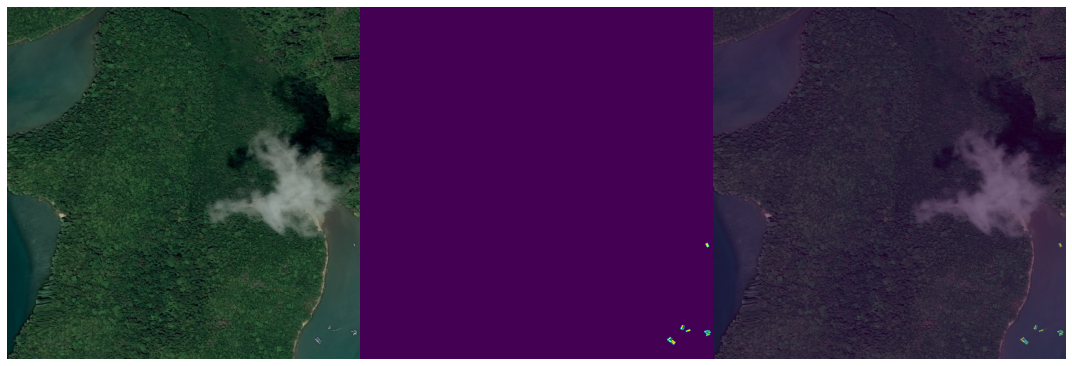

In [ ]:
ImageId = 'd3c47b3d3.jpg'

img_path = os.path.join(train_dir,ImageId)
img = plt.imread(img_path)

all_masks = read_mask(img_path)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

#Save mask to png (skip this)

In [ ]:
def save_mask(img_path, shape=(768, 768)):
    '''
    Save png mask
    img_path: path to image
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    image_name = os.path.basename(img_path)
    img_masks = masks_df.loc[masks_df['ImageId'] == image_name, 'EncodedPixels'].tolist()

    all_masks = np.zeros(shape)
    for mask in img_masks:
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        if (pd.isna(mask) != True):
            s = mask.split()
            starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
            starts -= 1
            ends = starts + lengths
            
            for lo, hi in zip(starts, ends):
                img[lo:hi] = 1
        all_masks += img.reshape(shape).T  
    #convert to 1 bit png
    im = Image.fromarray(all_masks*256).convert("1")
    im.save(f'{train_mask_dir}/{image_name}.png','PNG')

In [ ]:
!mkdir {train_masks_dir}

In [ ]:
train_images = sorted(glob.glob(os.path.join(train_dir, '*.jpg')))
for image_name in tqdm(train_images):
    save_mask(image_name)

100%|██████████| 192556/192556 [2:08:11<00:00, 25.04it/s]


In [ ]:
!zip -r train_masks.zip train_masks

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: train_masks/9afefdaaa.jpg.png (deflated 49%)
  adding: train_masks/f9e66a6fe.jpg.png (deflated 49%)
  adding: train_masks/0a00700bc.jpg.png (deflated 49%)
  adding: train_masks/04c2b51b9.jpg.png (deflated 49%)
  adding: train_masks/83fc8d739.jpg.png (deflated 49%)
  adding: train_masks/8cde69ddd.jpg.png (deflated 49%)
  adding: train_masks/bb117d99b.jpg.png (deflated 24%)
  adding: train_masks/1f64b9514.jpg.png (deflated 49%)
  adding: train_masks/c84ba9eb2.jpg.png (deflated 49%)
  adding: train_masks/4b222cd89.jpg.png (deflated 49%)
  adding: train_masks/4c67fc6c2.jpg.png (deflated 49%)
  adding: train_masks/860080d58.jpg.png (deflated 49%)
  adding: train_masks/90643a7a4.jpg.png (deflated 3%)
  adding: train_masks/d75145cf2.jpg.png (deflated 8%)
  adding: train_masks/27f5c6cb9.jpg.png (deflated 49%)
  adding: train_masks/9473261b6.jpg.png (deflated 49%)
  adding: train_masks/2c03d66e5.jpg.png (deflated 49%)

In [ ]:
!cp train_masks.zip '/content/drive/MyDrive/Colab Notebooks/Базы/train_masks.zip'

In [ ]:
#https://drive.google.com/file/d/1shDm90oUJimKSdu6bBa-VfZeFwUfqorz/view?usp=sharing

#Load masks

In [ ]:
import gdown
file_name = gdown.download('https://drive.google.com/uc?id=1shDm90oUJimKSdu6bBa-VfZeFwUfqorz')
!unzip {file_name}

Downloading...
From: https://drive.google.com/uc?id=1shDm90oUJimKSdu6bBa-VfZeFwUfqorz
To: /content/train_masks.zip
100%|██████████| 66.2M/66.2M [00:00<00:00, 100MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: train_masks/9afefdaaa.jpg.png  
  inflating: train_masks/f9e66a6fe.jpg.png  
  inflating: train_masks/0a00700bc.jpg.png  
  inflating: train_masks/04c2b51b9.jpg.png  
  inflating: train_masks/83fc8d739.jpg.png  
  inflating: train_masks/8cde69ddd.jpg.png  
  inflating: train_masks/bb117d99b.jpg.png  
  inflating: train_masks/1f64b9514.jpg.png  
  inflating: train_masks/c84ba9eb2.jpg.png  
  inflating: train_masks/4b222cd89.jpg.png  
  inflating: train_masks/4c67fc6c2.jpg.png  
  inflating: train_masks/860080d58.jpg.png  
  inflating: train_masks/90643a7a4.jpg.png  
  inflating: train_masks/d75145cf2.jpg.png  
  inflating: train_masks/27f5c6cb9.jpg.png  
  inflating: train_masks/9473261b6.jpg.png  
  inflating: train_masks/2c03d66e5.jpg.png  
  inflating: train_masks/d4ea0c049.jpg.png  
  inflating: train_masks/056c6cf9c.jpg.png  
  inflating: train_masks/af344fa35.jpg.png  
  inflating: train_masks/b390b185f.jpg.png  
  in

#Augmentation

In [ ]:
def read_image(image_path, mask=False):
    '''
    Function to upload an image.
    image_path - image path
    mask - flag determines whether a image or mask should be output
    output tf.image
    '''
    img_file = tf.io.read_file(image_path)
    if mask == False:
        image = tf.image.decode_jpeg(img_file, channels=3)
        image = tf.cast(image, tf.float32) / 127.5 - 1
    if mask:
        image = tf.image.decode_png(img_file, channels=1)
        # image = tf.squeeze(image)
        image = tf.cast(image, tf.float32) / 256 
    
    return image


def load_data(image_list, mask_list):
    # Loading image and masks
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    image, mask = random_jitter(image, mask)    #augmentation
    return image, mask

def get_dataset(image_list, mask_list):
    # Loading dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size)
    return dataset

In [ ]:
@tf.function()
def random_jitter(input_image, output_image):
    #augmentation

    # random crop of image
    input_image, output_image = random_crop(input_image, output_image, target_size[0], target_size[1])

    if tf.random.uniform(()) > 0.5:
    # random horisontal flip
        input_image = tf.image.flip_left_right(input_image)
        output_image = tf.image.flip_left_right(output_image)

    if tf.random.uniform(()) > 0.5:
    # random vertical flip
        input_image = tf.image.flip_up_down(input_image)
        output_image = tf.image.flip_up_down(output_image)

    if tf.random.uniform(()) > 0.5:
    # random rotation 90 degrees
        input_image = tf.image.rot90(input_image)
        output_image = tf.image.rot90(output_image)

    #brightness 10%, contrast 10%, saturation 20% 
    input_image = tf.image.random_brightness(input_image, 0.1)
    input_image = tf.image.random_contrast(input_image, 0.9, 1.1)
    input_image = tf.image.random_saturation(input_image, 0.8,1.2)
    #small hue shift
    input_image = tf.image.random_hue(input_image, 0.01)
    input_image = tf.clip_by_value(input_image,-1,1) # set values from -1 to 1
    #output_image = tf.clip_by_value(output_image,0,1)

    if tf.random.uniform(()) > 0.1:
    # random noise
        noise = tf.random.uniform((input_image.shape), .7, 0.99)
        input_image = tf.cast(input_image, tf.float32) * noise

    return input_image, output_image

def random_crop(input_image, output_image, height, width):
    '''
    Random crop image
    input_image - image
    output_image - masks
    height, width - size to crop
    '''
    # Image stack for synchronous cropping
    stacked_image = tf.concat([input_image, output_image], axis=-1)

    # random crop
    cropped_image = tf.image.random_crop(
        stacked_image, size=[height, width, 4])
    
    # unstack image and mask
    return cropped_image[..., :-1], tf.expand_dims(cropped_image[..., -1], -1)

#Data generate

In [ ]:
#size for validation data
val_split = len(os.listdir(train_dir)) // 10

#Loading train dataset
train_images = sorted(glob.glob(os.path.join(train_dir, '*.jpg')))[:-val_split]
train_masks = sorted(glob.glob(os.path.join(train_mask_dir, '*.png')))[:-val_split]

#Loading validation dataset
val_images = sorted(glob.glob(os.path.join(train_dir, '*.jpg')))[-val_split:]
val_masks = sorted(glob.glob(os.path.join(train_mask_dir, '*.png')))[-val_split:]


In [ ]:
def cut_empty(images,masks):
    #delete images and mask, where is not ships
    images_lst = []
    masks_lst = []
    df_tmp = masks_df.dropna().set_index('ImageId')
    for i in tqdm(range(len(images))):
        path_i = images[i]
        path_m = masks[i]
        name = os.path.basename(path_i)
        if(name in df_tmp.index):
            images_lst.append(path_i)
            masks_lst.append(path_m)
    return images_lst, masks_lst

train_images,train_masks = cut_empty(train_images,train_masks)
val_images,val_masks = cut_empty(val_images,val_masks)

100%|██████████| 300/300 [00:00<00:00, 54029.42it/s]


In [ ]:
# create train and validation dataset
train_dataset = get_dataset(train_images, train_masks)
val_dataset = get_dataset(val_images, val_masks)


print("Train Dataset lenght:", len(train_dataset))
print("Val Dataset lenght:", len(val_dataset))
print("\nTrain Dataset:", (train_dataset))
print("Val Dataset:", (val_dataset))

Train Dataset lenght: 9565
Val Dataset lenght: 17

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


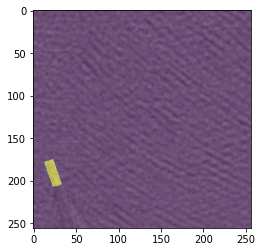

(4, 256, 256, 3) (4, 256, 256, 1)


In [ ]:
# Example image with mask from dataset
for img, mask in train_dataset:
    plt.imshow((img[0].numpy()*127.5+127.5).astype('int'))
    plt.imshow((np.squeeze(mask[0])), alpha=0.5)
    plt.show()
    break
print(img.shape, mask.shape)

#Model DeepLabV3+
https://keras.io/examples/vision/deeplabv3_plus/

In [ ]:
def convolution_block(
    x,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding='same',
    use_bias=True,
    kernel_regularizer=None
):
    x = layers.Conv2D(filters=num_filters,
                     kernel_size=kernel_size,
                     dilation_rate=dilation_rate,
                     padding=padding,
                     use_bias=use_bias,
                     kernel_initializer=tf.keras.initializers.HeNormal())(x)
    x = layers.BatchNormalization()(x)
    return tf.nn.leaky_relu(x)

def PyramidPooling(inputs): # 
    #Dilated Spatial Pyramid Pooling) 
    
    dims = inputs.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(inputs)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1],
              dims[-2] // x.shape[2]),
        interpolation='bilinear'
    )(x)
    
    out1 = convolution_block(inputs, kernel_size=1, dilation_rate=1)
    out6 = convolution_block(inputs, kernel_size=3, dilation_rate=6)
    out12 = convolution_block(inputs, kernel_size=3, dilation_rate=12)
    out18 = convolution_block(inputs, kernel_size=3, dilation_rate=18)
    
    x = layers.concatenate([out_pool, out1, out6, out12, out18])
    
    return convolution_block(x, kernel_size=1)

In [ ]:
def DeepLab(image_size):
    '''
    Create DNN with ResNet50 
    '''

    regularizer = tf.keras.regularizers.l1_l2(l1=0.001, l2=0.0001)
    
    inputs = layers.Input((*target_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_tensor=inputs
    )
    x = resnet50.get_layer('conv4_block6_2_relu').output
    x = PyramidPooling(x)
    
    input_a = layers.UpSampling2D(size=(target_size[0] // 4 // x.shape[1],
                                        target_size[1] // 4 // x.shape[2]),
                                 interpolation='bilinear')(x)
    
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=64, kernel_size=1, kernel_regularizer=regularizer)
    
    x = layers.concatenate([input_a, input_b])
    x = convolution_block(x, use_bias=True, kernel_regularizer=regularizer)
    x = convolution_block(x, use_bias=True, kernel_regularizer=regularizer)
    x = layers.UpSampling2D(size=(target_size[0] // x.shape[1],
                                  target_size[1] // x.shape[2]),
                           interpolation='bilinear')(x)

    outputs = layers.Conv2D(1, kernel_size=1, padding='same', activation=tf.nn.sigmoid)(x)
    
    return tf.keras.Model(inputs, outputs)

In [ ]:
class GCAdam(tf.keras.optimizers.Adam): 
    '''
    #https://arxiv.org/abs/2004.01461
    Gradient Centralization: Optimization techniques are of great importance to effectively 
    and efficiently train a deep neural network (DNN). 
    '''
    def get_gradients(self, loss, params):
        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads

def dice_coef(y_true, y_pred, smooth=1):
    '''
    Sorensen-Dyes metric to measure how similar two masks are
    '''
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return tf.reduce_mean((2. * intersection + smooth)/(union + smooth))

class Schedule():
    '''
    Decreasing training step schedule for a callback
    Decreasing starts at start_epoch and happens every per_epoch
    '''
    def __init__(self, start_epoch=5, per_epoch=1):
        self.start_epoch = start_epoch
        self.per_epoch = per_epoch

    def __call__(self, epoch, lr):
        if epoch >= self.start_epoch and epoch % self.per_epoch == 0:
            lr *= tf.math.exp(-0.1)
        print('learning rate:', float(lr))
        return lr

def weighted_binary_crossentropy(y_true, y_pred, weight=5.) :
    #weighted loss
    y_true = tf.keras.backend.clip(y_true, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())
    logloss = -(y_true * tf.keras.backend.log(y_pred) * weight + (1 - y_true) * tf.keras.backend.log(1 - y_pred))
    return tf.keras.backend.mean( logloss, axis=-1)

In [ ]:
model = DeepLab(target_size)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

#Train

In [25]:
# Train

epochs = 20 
loss = weighted_binary_crossentropy
optimizer = GCAdam(0.0002)
metrics = [tf.keras.metrics.BinaryAccuracy(),
           tf.metrics.MeanIoU(num_classes=2, name='IoU'), 
           dice_coef]

schedule_callback = tf.keras.callbacks.LearningRateScheduler(Schedule(10, 2))
#checkpoint for saving best model weights
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_DIR, 'airbus_weights.h5'), 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,
                                   mode='auto')
callbacks = [model_checkpoint,schedule_callback]

# model compilations
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    initial_epoch=0,
                    callbacks=callbacks
                    )

learning rate: 0.00019999999494757503
Epoch 1/20
9565/9565 [==============================] - ETA: 0s - loss: 0.0467 - binary_accuracy: 0.9881 - IoU: 0.5000 - dice_coef: 0.1905
Epoch 1: val_loss improved from inf to 0.05164, saving model to /content/drive/MyDrive/Colab Notebooks/saveModels/airbus_weights.h5
9565/9565 [==============================] - 1005s 104ms/step - loss: 0.0467 - binary_accuracy: 0.9881 - IoU: 0.5000 - dice_coef: 0.1905 - val_loss: 0.0516 - val_binary_accuracy: 0.9793 - val_IoU: 1.0000 - val_dice_coef: 0.2328 - lr: 2.0000e-04
learning rate: 0.00019999999494757503
Epoch 2/20
9564/9565 [============================>.] - ETA: 0s - loss: 0.0333 - binary_accuracy: 0.9891 - IoU: 1.0000 - dice_coef: 0.2389
Epoch 2: val_loss improved from 0.05164 to 0.04139, saving model to /content/drive/MyDrive/Colab Notebooks/saveModels/airbus_weights.h5
9565/9565 [==============================] - 982s 103ms/step - loss: 0.0333 - binary_accuracy: 0.9891 - IoU: 1.0000 - dice_coef: 0.23

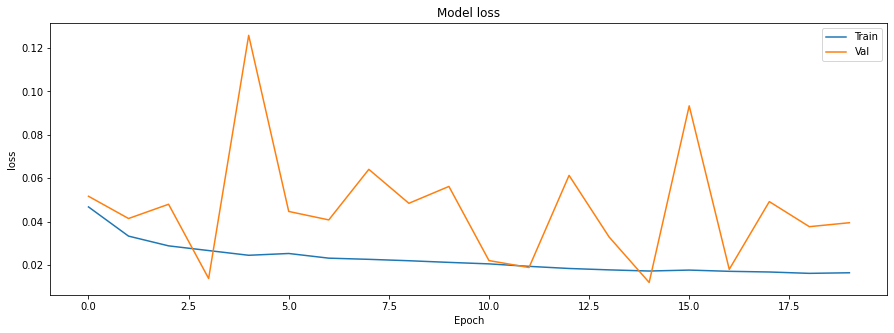

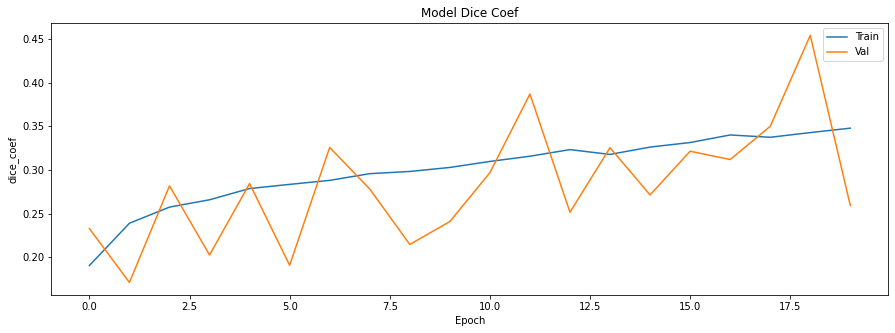

In [26]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'],label="Train")
plt.plot(history.history['val_loss'],label="Val")
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(history.history['dice_coef'],label="Train")
plt.plot(history.history['val_dice_coef'],label="Val")
plt.title('Model Dice Coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [27]:
model.save(os.path.join(MODEL_DIR, 'airbus_model2.h5'), include_optimizer=False)

#Predict

In [29]:
#load best weights
model.load_weights(os.path.join(MODEL_DIR, 'model.h5'))

In [30]:
model.evaluate(val_dataset)

17/17 [==============================] - 1s 41ms/step - loss: 0.0940 - binary_accuracy: 0.9899 - IoU: 1.0000 - dice_coef: 0.2392


[0.0940077155828476, 0.9898549914360046, 1.0, 0.23921369016170502]

In [31]:
def predict_mask(img, threshold = 0.5, pred_size = 256):
    """
    Predict mask
    img - input image (array)
    threshold - threshold for classes
    pred_size - size of window for cut

    Return mask (array)
    """
  # how many parts cut the picture, it will be necessary to create a mask
  mask_parts = [np.ceil(img.shape[0]/pred_size).astype(int), np.ceil(img.shape[1]/pred_size).astype(int)]
  #mask with a multiple of pred_size sides
  full_mask = np.zeros((mask_parts[0]*pred_size, mask_parts[1]*pred_size))

  patch = np.zeros((pred_size, pred_size, 3))

  # Pass through the analyzed image, pulling out sections of pred_size in size
  for i in range(0, img.shape[0], pred_size):
      for j in range(0, img.shape[1], pred_size):
            patch_img = img[i:i+pred_size, j:j+pred_size]
            patch = np.zeros((pred_size, pred_size, 3))
            patch[:patch_img.shape[0], :patch_img.shape[1]] = patch_img
            
            # predict mask
            pred = model.predict(np.expand_dims((patch / 127.5 -1), 0))

            #Use threshold
            pred[pred>=threshold] = 1
            pred[pred<threshold] = 0
            
            full_mask[i:i+pred_size, j:j+pred_size] = np.squeeze(pred)

  # Обрезаем лишнее по размеру картинки
  full_mask = full_mask[:img.shape[0], :img.shape[1]]
  return full_mask


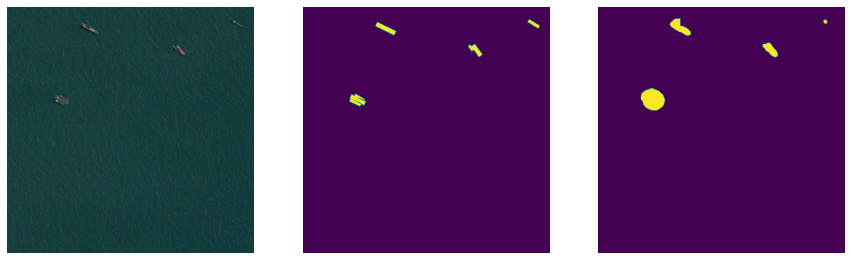

In [105]:
ImageId = train_data[45]

img_path = os.path.join(train_dir,ImageId)
img = plt.imread(img_path)

all_masks = read_mask(img_path)
predict_mask = predict_mask(img,0.5)
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(predict_mask)
plt.show()

In [106]:
def decode_mask(mask, shape=(768, 768)):
    #from image(mask) to run-length encoding
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [107]:
#predict all test images
test_data = os.listdir(test_dir)
ship_list_dict = []
    
for name in tqdm(test_data):
    img = plt.imread(os.path.join(test_dir, name))
    predict_mask = predict_mask(img,0.5)
    decode = decode_mask(predict_mask)
    ship_list_dict.append({'ImageId':name,'EncodedPixels':decode})


100%|██████████| 15606/15606 [2:06:27<00:00,  2.06it/s]


In [108]:
pred_df = pd.DataFrame(ship_list_dict)
pred_df.to_csv('submission.csv', index=False)
pred_df

,ImageId,EncodedPixels
0,852359907.jpg,
1,830ee8368.jpg,
2,45f8db321.jpg,
3,4e7103bf1.jpg,
4,64be1af23.jpg,
...,...,...
15601,e42e1dc38.jpg,
15602,5786bd5fe.jpg,
15603,fc06b3bd7.jpg,47646 2 48414 2 49182 3 49949 6 50716 8 51483 ...
15604,76222996f.jpg,


In [109]:
#load submission to kaggle
!kaggle competitions submit -c airbus-ship-detection -f submission.csv -m "20 epoch, treshold=0.5"

100% 3.21M/3.21M [00:00<00:00, 13.0MB/s]
Successfully submitted to Airbus Ship Detection Challenge